In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Load Latent Space Data

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


In [4]:

latent_dim = 10  # Adjust as needed

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        #z = self.sampling(z_mean, z_log_var)#added
        reconstruction = self.decoder(z)
        return reconstruction

    def sampling(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │            170 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │            170 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,348 (270.89 KB)

 Trainable params: 69,348 (270.89 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │          34,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,177 (352.25 KB)

 Trainable params: 90,177 (352.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Loading:
encoder = encoder  # Use the original encoder definition.
decoder = decoder  # Use the original decoder definition.
vae = VAE(encoder, decoder)

# Load weights:
encoder.load_weights("/content/drive/MyDrive/GSOC/GSOC/task2(g)/encoder_weights.weights.h5")
decoder.load_weights("/content/drive/MyDrive/GSOC/GSOC/task2(g)/decoder_weights.weights.h5")

print("VAE weights loaded, model reconstructed.")

# Load the data from the .npz file
data = np.load('/content/rotated_mnist (1).npz')

# Access the data arrays
rotated_x_train = data['x_train']
rotated_y_train = data['y_train']
rotated_x_test = data['x_test']
rotated_y_test = data['y_test']

# Print the shape of the data arrays to show the data cluster
print("Shape of rotated_x_train:", rotated_x_train.shape)
print("Shape of rotated_y_train:", rotated_y_train.shape)
print("Shape of rotated_x_test:", rotated_x_test.shape)
print("Shape of rotated_y_test:", rotated_y_test.shape)


VAE weights loaded, model reconstructed.
Shape of rotated_x_train: (152400, 28, 28)
Shape of rotated_y_train: (152400,)
Shape of rotated_x_test: (26004, 28, 28)
Shape of rotated_y_test: (26004,)


# Define Symmetry Transformation Network

In [10]:
import torch
import torch.nn as nn

class SymmetryNet(nn.Module):
    def __init__(self, latent_dim):
        super(SymmetryNet, self).__init__()
        self.fc1 = nn.Linear(latent_dim, latent_dim)  # Assuming latent_dim is the dimension of your latent space

    def forward(self, z):
        return torch.tanh(self.fc1(z))  # Use tanh for bounded output


#Define Loss Functions

In [11]:
def invariance_loss(transformed_logits, original_logits):
    return torch.mean((transformed_logits - original_logits) ** 2)

def normalization_loss(g_z):
    return torch.mean((torch.norm(g_z, dim=1) - 1) ** 2)

def orthogonality_loss(g1_z, g2_z):
    return torch.mean((g1_z * g2_z).sum(dim=1) ** 2)


In [13]:
import torch

# Assuming x_train_tensor is a list of tensors or a list of numpy arrays
# Convert it to a PyTorch tensor if necessary

x_train_tensor = torch.tensor(rotated_x_train).float() # Added this line to define x_train_tensor

if isinstance(x_train_tensor, list):
    x_train_tensor = torch.tensor(x_train_tensor)


latent_train = encoder(x_train_tensor)
if isinstance(latent_train, list):

    latent_train = torch.tensor(latent_train[0]) if isinstance(latent_train[0], np.ndarray) else latent_train[0]
else:
    latent_train = latent_train

# Convert TensorFlow EagerTensor to NumPy array
latent_train = latent_train.numpy()

#Train Symmetry Transformation

In [ ]:
# Initialize models and optimizer
'''symmetry_net = SymmetryNet(latent_dim=16)  # Assuming 16D latent space
classifier = Classifier()  # Assuming you have a classifier model
optimizer = torch.optim.Adam(symmetry_net.parameters(), lr=0.001)

# Train loop
epsilon = 0.01
for epoch in range(10):  # Simplified training loop
    for z in latent_data:
        z = torch.tensor(z).float()
        z_transformed = z + epsilon * symmetry_net(z)
        logits_original = classifier(z)
        logits_transformed = classifier(z_transformed)

        loss_inv = invariance_loss(logits_transformed, logits_original)
        loss_norm = normalization_loss(symmetry_net(z))

        loss = loss_inv + 0.1 * loss_norm  # Adjust hyperparameters as needed

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()'''''


In [ ]:
# Initialize models and optimizer
latent_dim = 16  # Assuming 16D latent space
symmetry_net = SymmetryNet(latent_dim)
classifier = Classifier()  # Assuming you have a classifier model
optimizer = torch.optim.Adam(symmetry_net.parameters(), lr=0.001)

# Define loss functions
def invariance_loss(transformed_logits, original_logits):
    return torch.mean((transformed_logits - original_logits) ** 2)

def normalization_loss(g_z):
    return torch.mean((torch.norm(g_z, dim=1) - 1) ** 2)

# Train loop
epsilon = 0.01
for epoch in range(10):  # Simplified training loop
    for z in latent_train:
        z = torch.tensor(z).float()
        z_transformed = z + epsilon * symmetry_net(z)
        logits_original = classifier(z)
        logits_transformed = classifier(z_transformed)

        loss_inv = invariance_loss(logits_transformed, logits_original)
        loss_norm = normalization_loss(symmetry_net(z))

        loss = loss_inv + 0.1 * loss_norm  # Adjust hyperparameters as needed

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [15]:
import torch
import torch.nn as nn

# Define classifier (oracle)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(10, 10)  # Output layer for 10 classes, adjusted input size to 10

    def forward(self, z):
        return self.fc1(z)


In [ ]:
# Initialize models and optimizer
latent_dim = 10  #  10 latent space
symmetry_net = SymmetryNet(latent_dim)
classifier = Classifier()  # Assuming you have a classifier model
optimizer = torch.optim.Adam(symmetry_net.parameters(), lr=0.001)

# Define loss functions
def invariance_loss(transformed_logits, original_logits):
    return torch.mean((transformed_logits - original_logits) ** 2)

def normalization_loss(g_z):
    return torch.mean((torch.norm(g_z, dim=0) - 1) ** 2)

# Train loop
epsilon = 0.01
for epoch in range(10):  # Simplified training loop
    for z in latent_train:
        z = torch.tensor(z).float()
        z_transformed = z + epsilon * symmetry_net(z)
        logits_original = classifier(z)
        logits_transformed = classifier(z_transformed)

        loss_inv = invariance_loss(logits_transformed, logits_original)
        loss_norm = normalization_loss(symmetry_net(z))

        loss = loss_inv + 0.1 * loss_norm  # Adjust hyperparameters as needed

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [18]:
import torch

# Convert latent_train to tensors
latent_train_tensors = torch.tensor(latent_train).float()


In [19]:
import torch
from torch.utils.data import Dataset

class LatentDataset(Dataset):
    def __init__(self, latent_data):
        self.latent_data = latent_data

    def __len__(self):
        return len(self.latent_data)

    def __getitem__(self, idx):
        return self.latent_data[idx]


In [20]:
# Initialize the dataset
latent_dataset = LatentDataset(latent_train_tensors)

# Create a DataLoader
batch_size = 64
latent_dataloader = torch.utils.data.DataLoader(latent_dataset, batch_size=batch_size, shuffle=True)


In [22]:
# Initialize models and optimizer
symmetry_net = SymmetryNet(latent_dim=10)  # Assuming 16D latent space
classifier = Classifier()  # Assuming you have a classifier model
optimizer = torch.optim.Adam(symmetry_net.parameters(), lr=0.001)

# Define loss functions
def invariance_loss(transformed_logits, original_logits):
    return torch.mean((transformed_logits - original_logits) ** 2)

def normalization_loss(g_z):
    return torch.mean((torch.norm(g_z, dim=1) - 1) ** 2)

# Train loop
epsilon = 0.01
for epoch in range(10):  # Simplified training loop
    for batch in latent_dataloader:
        batch = batch.float()  # Ensure batch is a float tensor
        z_transformed = batch + epsilon * symmetry_net(batch)
        logits_original = classifier(batch)
        logits_transformed = classifier(z_transformed)

        loss_inv = invariance_loss(logits_transformed, logits_original)
        loss_norm = normalization_loss(symmetry_net(batch))

        loss = loss_inv + 0.1 * loss_norm  # Adjust hyperparameters as needed

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


#Visualize Symmetry Transformations

In [ ]:
# Assuming you have a decoder function from your VAE
def decode_latent(z):
    # Implement decoding logic here
    pass

# Visualize transformations
for z in latent_data[:10]:  # Visualize first 10 samples
    z = torch.tensor(z).float()
    z_transformed = z + epsilon * symmetry_net(z)
    original_image = decode_latent(z)
    transformed_image = decode_latent(z_transformed)

    # Display original and transformed images
    import matplotlib.pyplot as plt
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image, cmap='gray')
    plt.show()


In [ ]:
def decode_and_visualize(z, z_transformed):
    # Decode the latent vectors
    original_image = decoder.predict(z.reshape(1, -1)).squeeze()
    transformed_image = decoder.predict(z_transformed.reshape(1, -1)).squeeze()

    # Visualize the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image, cmap='gray')
    plt.title('Transformed Image')
    plt.show()


z = np.random.rand(10)  # Replace with actual latent vector
z_transformed = z + np.random.rand(10) * 0.1  # Simulate transformation
decode_and_visualize(z, z_transformed)


In [ ]:
# Visualize transformations
for z in latent_train[:10]:  # Visualize first 10 samples
    z = torch.tensor(z).float()
    z_transformed = z + epsilon * symmetry_net(z)
    original_image = decoder(z).detach().numpy().squeeze()
    transformed_image = decoder(z_transformed).detach().numpy().squeeze()

    # Display original and transformed images
    import matplotlib.pyplot as plt
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image, cmap='gray')
    plt.show()


In [23]:
# Select first 10 samples for visualization
visualize_samples = latent_train[:10]


In [24]:
# Convert samples to tensors
visualize_samples_tensors = torch.tensor(visualize_samples).float()

# Apply symmetry transformation
epsilon = 0.01
transformed_samples = visualize_samples_tensors + epsilon * symmetry_net(visualize_samples_tensors)


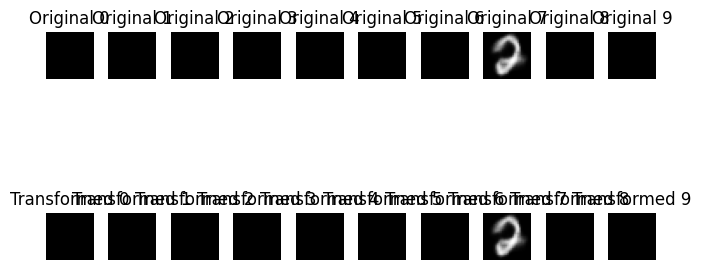

In [27]:
# Decode original and transformed samples
original_images = decoder(visualize_samples_tensors).numpy()
transformed_images = decoder(transformed_samples.detach()).numpy() # Detach before converting to numpy

# Visualize original and transformed images
import matplotlib.pyplot as plt

for i in range(len(original_images)):
    plt.subplot(2, len(original_images), i+1)
    plt.imshow(original_images[i].squeeze(), cmap='gray')
    plt.title(f"Original {i}")
    plt.axis('off')

    plt.subplot(2, len(original_images), len(original_images)+i+1)
    plt.imshow(transformed_images[i].squeeze(), cmap='gray')
    plt.title(f"Transformed {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()